# Support Vector Machine :  Problem 2
## Classification with Soft Margins

## Disclaimer
These exercises are based on the Stanford Machine Learning Course [CS229](http://cs229.stanford.edu) of Andrew Ng. The environment of the exercise have been tuned to the theory content taught at Ravensburg Weingarten University.

We are using the Python programming language. If you don't know Python or if you would like to refresh your memory, take a look at the [Python tutorial](http://docs.python.org/tut/).
We will mostly work with NumPy, the fundamental package for scientific computing in Python. Please read the [NumPy quickstart tutorial](https://numpy.org/devdocs/user/quickstart.html). In addition, the documention of MatPlotLib and Scipy lib can be found here: .[MatplotLib](https://matplotlib.org/). [Scipy](https://docs.scipy.org/doc/scipy/reference/tutorial/).

### 2.A Dataset

In this exercise, you will be using support vector machines
(SVMs) with example 2D dataset. Experimenting with these datasets
will help you gain an intuition of how SVMs work and how to use a Gaussian
kernel with SVMs.


In [1]:
# Used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
import matplotlib.pyplot as plt

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# for plotting grayscale
from PIL import Image

import pandas as pd

In [2]:
df = pd.read_csv('./data/ex6data2.csv')
X = df[['x','y']].values 
y = df['label'].values
(n,d) = X.shape

m = y.size
print('There are total of {} points in dataset'.format(m))

There are total of 863 points in dataset


In [3]:
def plot(X,y):

    # Find Indices of Positive and Negative Examples, to visualize separately
    pos = y == 1
    neg = y == -1
    
    # Plot example
    plt.plot(X[pos, 0], X[pos, 1], '*', mfc='b',ms=10)
    plt.plot(X[neg, 0], X[neg, 1], 'ko', mfc='g', ms=8)
    plt.grid(b=None, which='major', axis='both')
    plt.legend(['Pos', 'Neg'])
    plt.title('Class Plot')
    plt.xlabel('x')
    plt.ylabel('y')

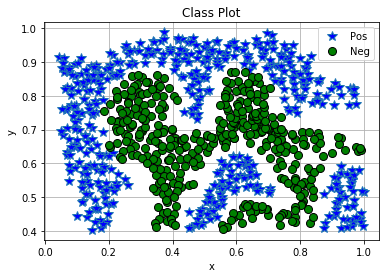

In [4]:
plot(X,y)

## Soft margin SVM Primal Optimization


**Why soft margins are needed ?**

Normally, in case of outliers, the model tries to Overfit and generates a so-called 'hard margins'. In this case, we can use slack variable ($\xi_i$). The points are then allowed to have margin of slightly less than 1, but then the cost of objective function will increase by a factor of $C\xi_i$.

In this part of the exercise, you will try using different values of the $C$
parameter with SVMs. Informally, the $C$ parameter is a positive value that
controls the penalty for misclassified training examples. A large $C$ parameter 
tells the SVM to try to classify all the examples correctly. 

Given a training set $\{(x_i, y_i) \}$ with $1 \leq i \leq n, x_i \in \mathbb{R}^d, y_i \in \{+1, −1\}$, recall that the primal
SVM optimization problem is usually written as:

$$
\begin{align}
\min_{w,b}\quad & \lVert w \rVert^2 + C \sum_{i=1}^n \xi_i \\
\text{s.t.}\quad & y_i(w^Tx_i + b) \geq 1 - \xi_i\\
& \xi_i \geq 0
\end{align}
$$

In this part of the exercise, we will be using SVMs to do non-linear classification.
In particular, you will be using SVMs with Gaussian kernels on
datasets that are not linearly separable.

<img src='./graphic/1.png' width='650' height='650'>

### 2.B Gaussian Kernel
To find non-linear decision boundaries with the SVM, we need to first implement
a Gaussian kernel. You can think of the Gaussian kernel as a similarity function that measures the "distance" between a pair of examples, $(x, z)$ with $x,z\in\mathbb{R}^d$. The Gaussian kernel is also parameterized by a bandwidth parameter, $\sigma$, which determines how fast the similarity metric decreases (to $0$) as the examples are further apart. 

The Gaussian kernel function is defined as

$$
k(x,z) = \exp \Big( -\frac{\lVert x-z\rVert^2}{2\sigma^2} \Big)
$$

You should now complete the code in `gaussianKernel` to compute
the Gaussian kernel between two examples, ($x^{(i)}$, $x^{(j)}$) simply called `x` and `z` in the function.

In [5]:
def gaussianKernel(x, z, sigma):
    diff = x-z
    return np.exp(-0.5 * np.dot(diff,diff.T)/sigma**2 ) 

**Test Kernel function**

In [6]:
x = np.array([1, 2,  1])
z = np.array([0, 4, -1])

sigma = 2
sim = gaussianKernel(x, z, sigma)

print('Value of Gaussian Kernel is {}'.format(sim))
#this value should be about 0.325

Value of Gaussian Kernel is 0.324652467358


Now implement a vectorized version of `gaussianKernel` such that it returns the Gram matrix  (sometimes also called a "kernel matrix"), $K\in \mathbb{R}^{n\times m}$ with

$$
K_{ij} = k(x^{(i)},z^{(j)})
$$

where $x^{(i)}$ is the $i$th row in $X$ and $z^{(j)}$ is the $j$th row in $Z$.

In [7]:
def gaussianKernelVec(X, Z, sigma):
    
    # Find shapes of matrices
    (n,d) = X.shape
    (m,d) = Z.shape
    
    # Intitiate empty matrix
    K = np.zeros((n,m))
    
    for i in range(0,n):
        for j in range(0,m):
            K[i,j] = gaussianKernel(X[i,:], Z[j,:], sigma)
    return K

**Test Vector Kernel Funct**

In [8]:
XX = np.random.rand(3,2)
ZZ = np.random.rand(2,2)

K1 = gaussianKernelVec(XX, ZZ, sigma=.5)

print('Gram Matrix: {}'.format(K1))

Gram Matrix: [[0.92526542 0.530739  ]
 [0.28354173 0.87699946]
 [0.91579805 0.63843231]]


### SVM Dual Form

Recall the primal support vector machine optimization problem above.
We can form the Lagrangian:
$$
\mathcal{L}(w,b,\xi,\alpha,\beta) = \frac{1}{2}w^Tw + C\sum_{i=1}^n \xi_i - \sum_{i=1}^n\alpha_i[y_i(x_i w+b) -w +\xi_i] - \sum_{i=1}^n\beta_i\xi_i
$$

Here, the $\alpha_i$'s and $\beta_i$'s are our Lagrange multipliers (constrained to be $\geq 0$).
We won’t go through the derivation of the dual again in detail, but after
setting the derivatives with respect to w and b to zero as before, substituting
them back in, and simplifying, we obtain the following dual form of the
problem:

$$
\begin{align}
\max_{\alpha} \quad & \sum_{i=1}^n \alpha_i - \frac{1}{2} \sum_{i,j=1}^n y_iy_j\alpha_i\alpha_j \langle x_i, x_j \rangle \\
\text{s.t.}\quad & 0\leq \alpha_i\leq C\\
& \sum_{i=1}^n \alpha_i y_i = 0
\end{align}
$$

We know that $w$ can be expressed in terms of the $\alpha_i$'s given by
$$
w = \sum_{i=1}^n \alpha_i y_i x_i,
$$
so that after solving the dual problem, we can use
$$
f(x) = w^Tx+b = \sum_{i=1}^n \alpha_i y_i \langle x_i, x \rangle +b
$$
to make our predictions.

Since the algorithm can be written entirely in terms of the inner products
$\langle x, z \rangle$, this means that we would replace all those inner products with
$\langle \phi(x), \phi(z) \rangle$. Specificically, given a feature mapping $\phi$, we define the corresponding
Kernel to be

$$
k(x, z) = \langle \phi(x), \phi(z) \rangle.
$$

Then, everywhere we previously had $\langle x, z \rangle$ in our algorithm, we could simply
replace it with $k(x, z)$, and our algorithm would now be learning using the
features $\phi$.

### 2.C Solving the SVM Dual Optimization problem with Quadratic Programming

The SVM dual problem can be optimized by quadratic programming. You need to download and install a third party library called "cvxopt". It is a python library for convex optimization problems.

**You may want to look into this : https://cvxopt.org/examples/tutorial/qp.html**

Quadratic programming is a general optimization routine to find a minimum for a problem specified by
$$
\begin{align}
\min_x\quad& \frac{1}{2} x^TPx + q^Tx\\
\text{s.t.}\quad & Gx \leq h\\
& Ax = b
\end{align}
$$
and we have to bring the SVM dual into this form.

In [9]:
import cvxopt

def quadprog(P,q,G,h,A,b):
    
    sol = cvxopt.solvers.qp(cvxopt.matrix(P), 
                      cvxopt.matrix(q), 
                      cvxopt.matrix(G), 
                      cvxopt.matrix(h), 
                      cvxopt.matrix(A), 
                      cvxopt.matrix(b))
    return np.ravel(sol['x'])

#### The Quadratic Program
We write the SVM optimization problem as a Quadratic Program.
Let $K$ be the Gram matrix with $K_{i,j} = k(x_i,x_j)$ then

$$
\begin{align}
P & = yy^T \circ K\\
q & = [-1, -1, -1, \dotsc, -1] = [-1]\\
G & = [-I, I]^T\\
h & = [0, 1\cdot C]^T\\
A & = y\\
b & = 0
\end{align}
$$

where $[1]$ is a vector with $n$ ones and $I$ is the identity matrix of size $n\times n$.

The function `lagrange_multipliers` below calculates these quantities and calls `quadprog` to obtain the $\alpha$'s.

In [10]:
def lagrange_multipliers(X, y, C, K):
    
    # Compute all matrices and then call cvxopt library
    (n,d) = X.shape

    P = np.outer(y, y) * K
    q = np.ones(n)*-1

    # -a_i <= 0
    Gs = np.eye(n)*-1
    hs = np.zeros(n)

    # a_i <= C
    Ge = np.eye(n)
    he = np.ones(n) * C

    G = np.vstack((Gs, Ge))
    h = np.hstack((hs, he))

    A = np.reshape(y,(1,n))
    b = 0.0

    alpha = quadprog(P, q, G, h, A, b)
    return alpha

The optimal bias $b$ can be determined by KKT dual-complementarity conditions which quarantees that
$$
y_i (w^Tx_i + b) = 1 \quad\text{if}\quad 0 < \alpha_i < C
$$
and hence
$$
\begin{align}
y_i (w^Tx_i + b) &= 1\\
w^Tx_i + b &= y_i\\
b &= y_i - w^Tx_i\\
&= y_i - \sum_{j=1}^n \alpha_j y_j k(x_j, x_i)
\end{align}
$$
for any $0 < \alpha_i < C$.

Implement the function `bias` below which returns $b$.

In [11]:
def bias(X, y, C, alpha, K):
    # for stability, we use not a single alpha but all alphas which fulfill the KKT critera.
    # And then average the result
    
    idx = (alpha > 1e-5) & (alpha < C)
    beta = alpha[idx]*y[idx]
    bs = y[idx] - np.dot(K[idx,:][:,idx],beta)
    return np.mean(bs)

We now have function to calculate $\alpha$ and $b$. This allows us to implement the support vector machine learning routine. 
The function `svm_learn` below first computes $\alpha$ and $b$ and then returns a function 
$$
z\mapsto \sum_{i=1}^n \alpha_i y_i k(x_i, z) +b
$$
which is able to make predictions for new data point $z$.

In [12]:
def svm_learn(X,y,C,kernel):
    
    # Kernel function is an argument here
    K = kernel(X,X)                         # kernel (Gram) matrix
    alpha = lagrange_multipliers(X,y,C,K)   # obtain lagrange multiplier 
    b = bias(X,y,C,alpha,K)                 # calculate bias
    
    # Select support vectors.
    sidx = alpha > 1e-5
    SVs = X[sidx, :]    
    
    # SVM classification function
    def f(Z):
        K = kernel(SVs, Z) # compute kernel matrix
        beta = np.diag(alpha[sidx]*y[sidx])
        return np.sum(np.dot(beta,K),axis=0) + b

    return f

In [13]:
def plot_decision(model, points):
    
    # find min and max
    x1lim = np.array([min(points[:, 0]), max(points[:, 0])])
    x2lim = np.array([min(points[:, 1]), max(points[:, 1])])
    
    # create grid to evaluate model
    x1 = np.linspace(x1lim[0], x1lim[1], 50)
    x2 = np.linspace(x2lim[0], x2lim[1], 50)
    Y, X = np.meshgrid(x2, x1)

    # shape data in x1,x2 points
    xy = np.transpose(np.vstack([X.ravel(), Y.ravel()]))
    
    # compute the decision boundary based on the learned model
    P = model(xy).reshape(X.shape) 
    
    # plot
    plt.contour(X, Y, P, levels=[0,0.1], alpha=0.5, linestyles=['-'])

     pcost       dcost       gap    pres   dres
 0: -1.0682e+02 -1.3574e+03  5e+03  2e+00  2e-15
 1: -6.9182e+01 -6.8305e+02  8e+02  1e-01  3e-15
 2: -8.2091e+01 -2.1167e+02  1e+02  2e-02  2e-15
 3: -1.0114e+02 -1.4667e+02  5e+01  5e-03  2e-15
 4: -1.0751e+02 -1.3336e+02  3e+01  2e-03  2e-15
 5: -1.1286e+02 -1.2291e+02  1e+01  7e-04  3e-15
 6: -1.1550e+02 -1.1808e+02  3e+00  4e-05  3e-15
 7: -1.1630e+02 -1.1697e+02  7e-01  1e-14  3e-15
 8: -1.1657e+02 -1.1666e+02  9e-02  5e-15  3e-15
 9: -1.1661e+02 -1.1662e+02  9e-03  7e-15  3e-15
10: -1.1661e+02 -1.1661e+02  1e-04  2e-14  3e-15
11: -1.1661e+02 -1.1661e+02  2e-06  4e-14  3e-15
Optimal solution found.


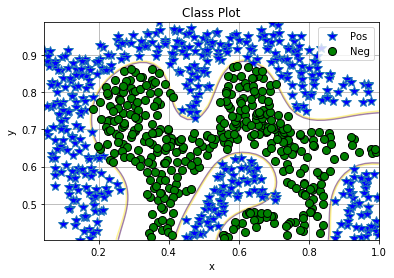

In [14]:
sigma = 0.1
C = 1
svm = svm_learn(X, y, C, lambda X, Y: gaussianKernelVec(X, Y, sigma))

plot(X,y)
plot_decision(svm, X)

### 2.D Overfit ?

**Try with a high value of C and see that the model tries to classify the train data too nicely.**

     pcost       dcost       gap    pres   dres
 0:  1.5310e+05 -2.4246e+06  4e+06  2e-01  1e-13
 1:  1.1994e+05 -3.4739e+05  6e+05  2e-02  1e-13
 2:  4.0156e+04 -9.7048e+04  1e+05  4e-03  8e-14
 3:  1.0734e+04 -2.5709e+04  4e+04  8e-04  5e-14
 4:  2.4442e+03 -7.6920e+03  1e+04  2e-04  4e-14
 5:  4.6199e+02 -3.6261e+03  4e+03  5e-05  4e-14
 6: -2.8021e+02 -2.0981e+03  2e+03  1e-05  4e-14
 7: -5.4270e+02 -1.6069e+03  1e+03  2e-06  4e-14
 8: -6.6028e+02 -1.3793e+03  7e+02  1e-06  4e-14
 9: -7.9496e+02 -1.0944e+03  3e+02  3e-07  5e-14
10: -8.5135e+02 -9.8350e+02  1e+02  1e-13  5e-14
11: -8.9839e+02 -9.1509e+02  2e+01  2e-13  6e-14
12: -9.0534e+02 -9.0609e+02  7e-01  5e-13  6e-14
13: -9.0568e+02 -9.0570e+02  3e-02  4e-13  6e-14
14: -9.0569e+02 -9.0569e+02  5e-04  4e-13  5e-14
Optimal solution found.


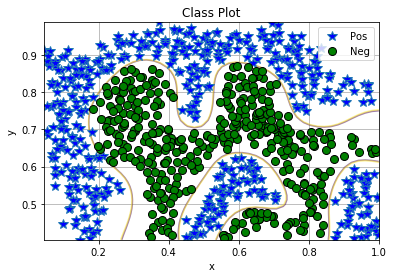

In [15]:
C = 100
svm = svm_learn(X, y, C, lambda X, Y: gaussianKernelVec(X, Y, sigma))

plot(X,y)
plot_decision(svm, X)

# What can you further contribute to this Notebook ?